## Motivation {.unnumbered}

For this dataset, each sample is comprised of cells from multiple patients hashtagged with a unique oligo sequence. To demultiplex which patient the cells were retrieved from, a demultiplexing algorithm must be used to quantify the oligo sequences for each cell and assign each cell to a patient. The most common approaches to date is using the HTOdemux [[Stoeckius et al.; 2018]](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1) or the MULTIseqDemux [[McGinnis et al.; 2019]](https://www.nature.com/articles/s41592-019-0433-8) algorithms. Besides assigning each cell back to each patient, these algorithms are able to identify homolytic/heterolytic "Doublet" and "Negative" cells based on high/multiple and low oligo counts respectively. These poor quality droplets are a common issue with droplet-based sequencing when there are multiple or no cells found in each droplet, and removal of these droplets could prevent false-positive findings.

:::{.callout-note}
## Aim
* Run HTODemux, MULTIseqDemux pipelines to demultiplex cells.
* Compare their strengths and efficiency.


:::

## Setup

In [1]:
# set up environment
suppressMessages({
library(scUnify)
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE247917")})

# load seurat objects
obj.list <- qread("seurat/1_processing/1.2_GSE247917_raw.qs")

Warning message:
“replacing previous import ‘cowplot::get_legend’ by ‘ggpubr::get_legend’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘cowplot::align_plots’ by ‘patchwork::align_plots’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘biomaRt::select’ by ‘rstatix::select’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘scales::viridis_pal’ by ‘viridis::viridis_pal’ when loading ‘scUnify’”


In [ ]:
# inspect object and make sure active assay is RNA
obj.list

$CV10
An object of class Seurat 
23862 features across 19484 samples within 3 assays 
Active assay: RNA (23797 features, 0 variable features)
 1 layer present: counts
 2 other assays present: HTO, ADT

$CV12
An object of class Seurat 
16451 features across 17366 samples within 3 assays 
Active assay: RNA (16386 features, 0 variable features)
 1 layer present: counts
 2 other assays present: HTO, ADT


## Calculate Gene Fractions {#sec-calculate_gene_fractions}
Before demultiplexing, we need to first calculate the fraction of mitochondrial, ribosomal, haemoglobin, T/B-cell recepter (TCR/BCR) and MHC reads to identify poor quality cells, which can be informative of accurate demultiplexing. The function below will perform the calculations of key parameters that identifies poor quality cells.

:::{.callout-note}
Please navigate to the next chapter \<Quality Control\> for a detailed explanation of the wrapper function, outputs, and interpretations.
:::

In [ ]:
## calculate gene fractions (mt, rb, hb, tcr, bcr, mhc)
for(x in 1:length(obj.list)){
    obj.list[[x]] <- calculate_fractions(obj.list[[x]])}

## Inpect HTO Counts
Before demultiplexing HTO library, we will inspect and remove any redundant/low expressing hashtags. For each sample, below we will quantify the expression levels for for each hashtag in each sample.

> Quantification show that all hashtags are abundantly expressed across the samples and can therefore proceed to demultiplexing.

In [ ]:
# calculate how many cells expresses each tag
metalist <- list()
for(x in 1:length(obj.list)){
    metalist[[x]] <- data.frame(sample = names(obj.list)[x], count = apply(obj.list[[x]][["HTO"]]$counts, 1, function(row) sum(row != 0)))}
metalist <- bind_rows(metalist)
metalist

,sample,count
,<chr>,<int>
CV-011-d120-booster,CV10,16404
CV-001-d28-booster,CV10,16189
CV-001-d7-booster,CV10,19476
CV-001-d0-booster,CV10,17218
CV-053-d28-vax,CV12,9232
CV-053-d21-vax,CV12,12223
CV-053-d7-vax,CV12,10337
CV-053-d0-vax,CV12,11173


## Run HTODemux {#sec-htodemux}
First we will run the the wrapper function below to demultiplex the cells with the HTODemux algorithm in default settings.

In [ ]:
# if necessary, add one pseudocount to each oligo to run HTODemux without error
for(x in 1:length(obj.list)){
    obj.list[[x]] <- run_htodemux(obj.list[[x]], add.one = F)}

Normalizing layer: counts

Normalizing across cells

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
Cutoff for CV-011-d120-booster : 57 reads

Cutoff for CV-001-d28-booster : 49 reads

Cutoff for CV-001-d7-booster : 146 reads

Cutoff for CV-001-d0-booster : 49 reads

Normalizing layer: counts

Normalizing across cells

Cutoff for CV-053-d28-vax : 20 reads

Cutoff for CV-053-d21-vax : 2 reads

Cutoff for CV-053-d7-vax : 8 reads

Cutoff for CV-053-d0-vax : 24 reads



Below we will visualize the output from HTODemux to inspect the quality of the demultiplexing algorithm. We quantified the percentage of "Singlet", "Doublet" and "Negative" cells (empty droplets or cells with no tags) for each sample. 

> HTODemux assigned <50 % of cells as "Singlet", which is not great.

In [ ]:
# aggregate HTODemux output into a dataframe
metalist <- list()
for(x in seq_along(obj.list)){
    metalist[[x]] <- obj.list[[x]]@meta.data}
metalist <- bind_rows(metalist)

## Quantify % of Singlet cells left from each sample
metalist_qc <- metalist %>%
    group_by(samples, HTO_classification.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    filter(!HTO_classification.global %in% c("Doublet", "Negative")) %>%
    group_by(samples) %>%
    summarize(pct = sum(pct))
    
metalist_qc

samples,pct
<chr>,<dbl>
CV10,49.19421
CV12,26.30427


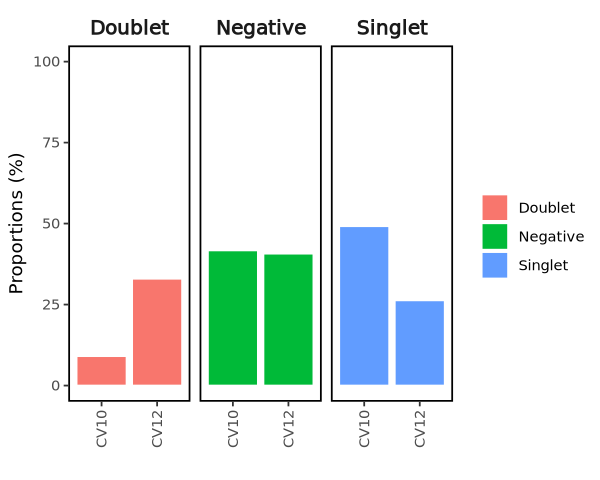

In [ ]:
# visualize % of singlet cells from each sample
options(repr.plot.width=5, repr.plot.height=4)
metalist %>%
    group_by(samples, HTO_classification.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = samples, y = pct, fill = HTO_classification.global)) +
    geom_col(color = "white") +
    facet_wrap(~HTO_classification.global) +
    guides(fill = guide_legend(title = "")) +
    theme_bw() +
    ylim(c(0, 100)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("Proportions (%)") +
    theme_border() +
    facet_aes()

In addition, we can inspect different parameter below to see if "Doublet" and "Negative" cells are assigned appropriately. Low nFeature/nCount typically indicate if the droplet is empty, hence "Negative". Vice versa, high nFeature/nCount indicate "Doublet" cells as mRNA contents in a droplet is doubled.

> HTODemux assignments do reflect nature of the "Negative" and "Doublet" cells in our case looking at nFeature_RNA & nCounts_RNA mainly.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


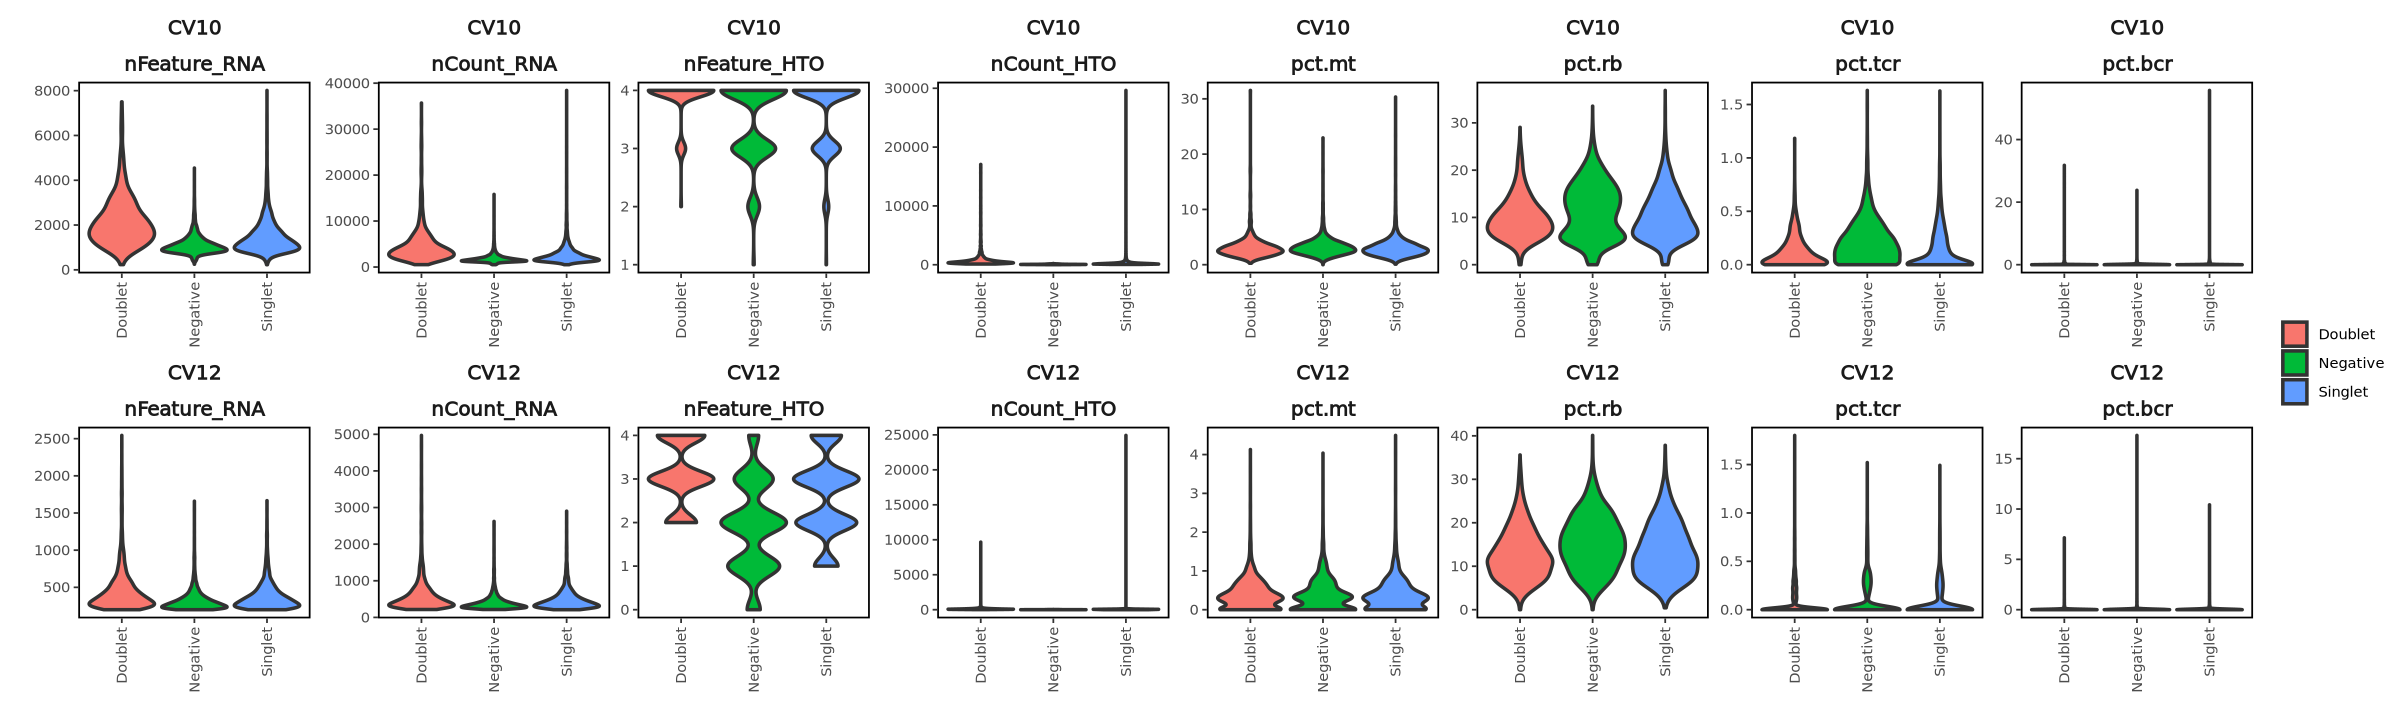

In [ ]:
# inspect filtering parameters after HTODemux assignment
options(repr.plot.width=20, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
metalist %>%
    filter(!is.na(HTO_classification.global)) %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = HTO_classification.global, y = values, fill = HTO_classification.global)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## Run MULTIseqDemux {#sec-multiseqdemux}
Next we also will also implement MULTIseqDemux algorithm as a benchmark. HTODemux has been suggested to predict more false-positive doublets compared to MULTIseqDemux (see [GitHub](https://github.com/chris-mcginnis-ucsf/MULTI-seq/issues/26) & [Paper](https://academic.oup.com/bioinformatics/article-abstract/38/10/2791/6565315))

In [ ]:
# run MULTIseqDemux
for(x in 1:length(obj.list)){
    obj.list[[x]] <- run_multiseqdemux(obj.list[[x]], add.one = F)}

Normalizing layer: counts

Normalizing across cells

Normalizing layer: counts

Normalizing across cells



Below we will visualize the output from MULTIseqDemux to inspect the quality of demultiplexing. Again we quantified the percentage of "Singlet", "Doublet" and "Negative" cells for each sample.  

> MUTLIseqDemux assigned >80% and >40 % of cells assigned as "Singlet" in CV10 and CV12 respectively, seemingly capturing more cells compared to HTODemux.

In [ ]:
# aggregate MULTIseqDemux output into a dataframe
metalist <- list()
for(x in seq_along(obj.list)){
    metalist[[x]] <- obj.list[[x]]@meta.data}
metalist <- bind_rows(metalist)

# quantify % of Singlet cells left from each sample
metalist_qc <- metalist %>%
    group_by(samples, MULTI.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    filter(!MULTI.global %in% c("Doublet", "Negative")) %>%
    group_by(samples) %>%
    summarize(pct = sum(pct))

metalist_qc

samples,pct
<chr>,<dbl>
CV10,84.33587
CV12,42.67534


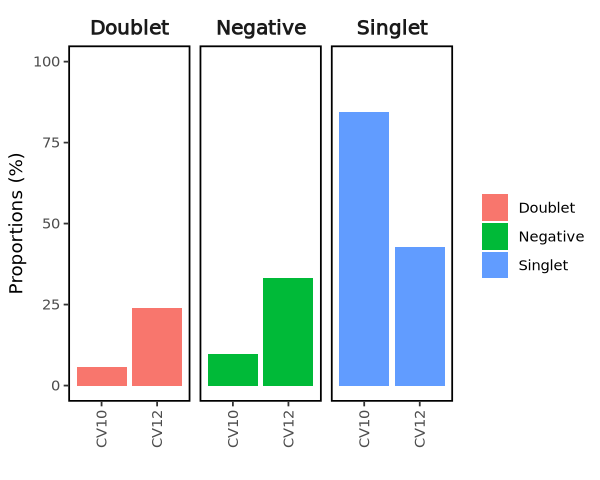

In [ ]:
# visualize % of singlet cells left from each sample
options(repr.plot.width=5, repr.plot.height=4)
metalist %>%
    group_by(samples, MULTI.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = samples, y = pct, fill = MULTI.global)) +
    geom_col() +
    facet_wrap(~MULTI.global) +
    guides(fill = guide_legend(title = "")) +
    ylim(c(0, 100)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("Proportions (%)") +
    theme_border() +
    facet_aes()

Again, we can inspect different parameter below to see if "Doublet" and "Negative" cells are assigned appropriately.


> MULTIseqDemux assignments also reflect nature of the "Negative" and "Doublet" cells looking at nFeature_RNA & nCounts_RNA mainly.

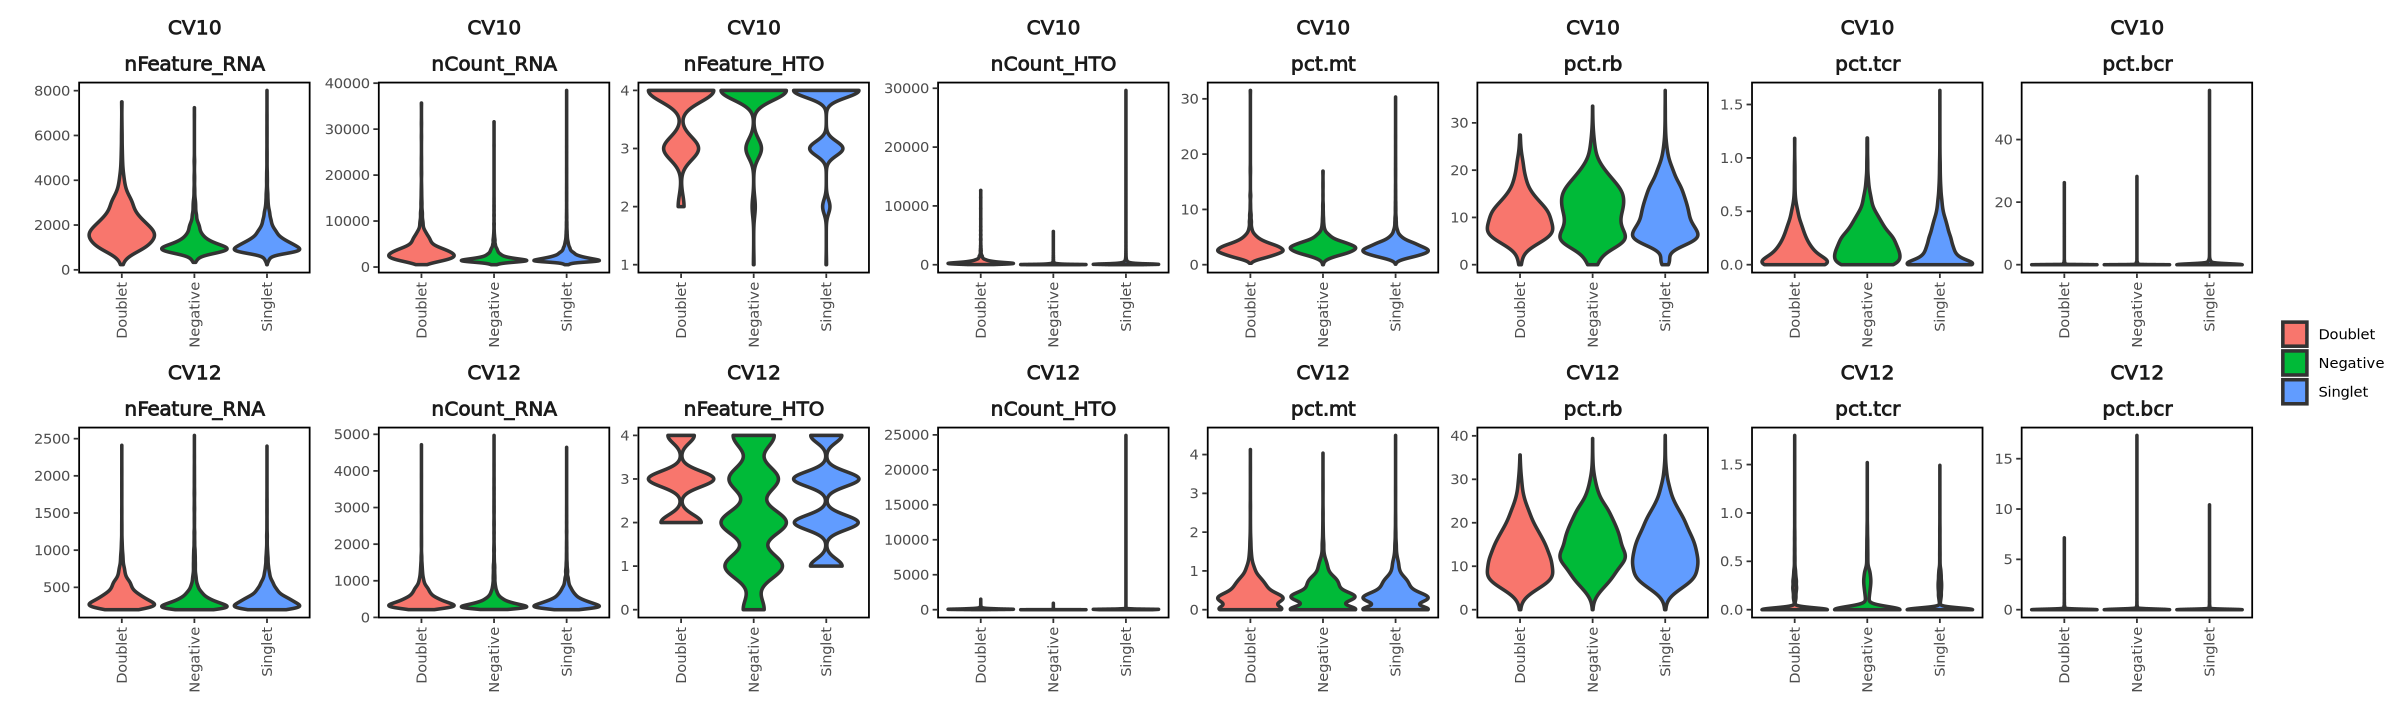

In [ ]:
# inspect filtering parameters after MULTIseqDemux assignment
options(repr.plot.width=20, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
metalist %>%
    filter(!is.na(MULTI.global)) %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = MULTI.global, y = values, fill = MULTI.global)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## Separate HTO Signals {#sec-htosignal}
Furthermore we will inspect how well HTODemux and MULTIseqDemux separated the hashtag signals in both samples.

> MULTIseqDemux seems to perform slightly better in terms of separating the hashtag signals in both sequencing runs with minimal overlaps, especially for CV-053-d21-vax.

Picking joint bandwidth of 0.0667

Picking joint bandwidth of 0.0643

Picking joint bandwidth of 0.109

Picking joint bandwidth of 0.0714

Picking joint bandwidth of 0.0729

Picking joint bandwidth of 0.0678

Picking joint bandwidth of 0.11

Picking joint bandwidth of 0.0698



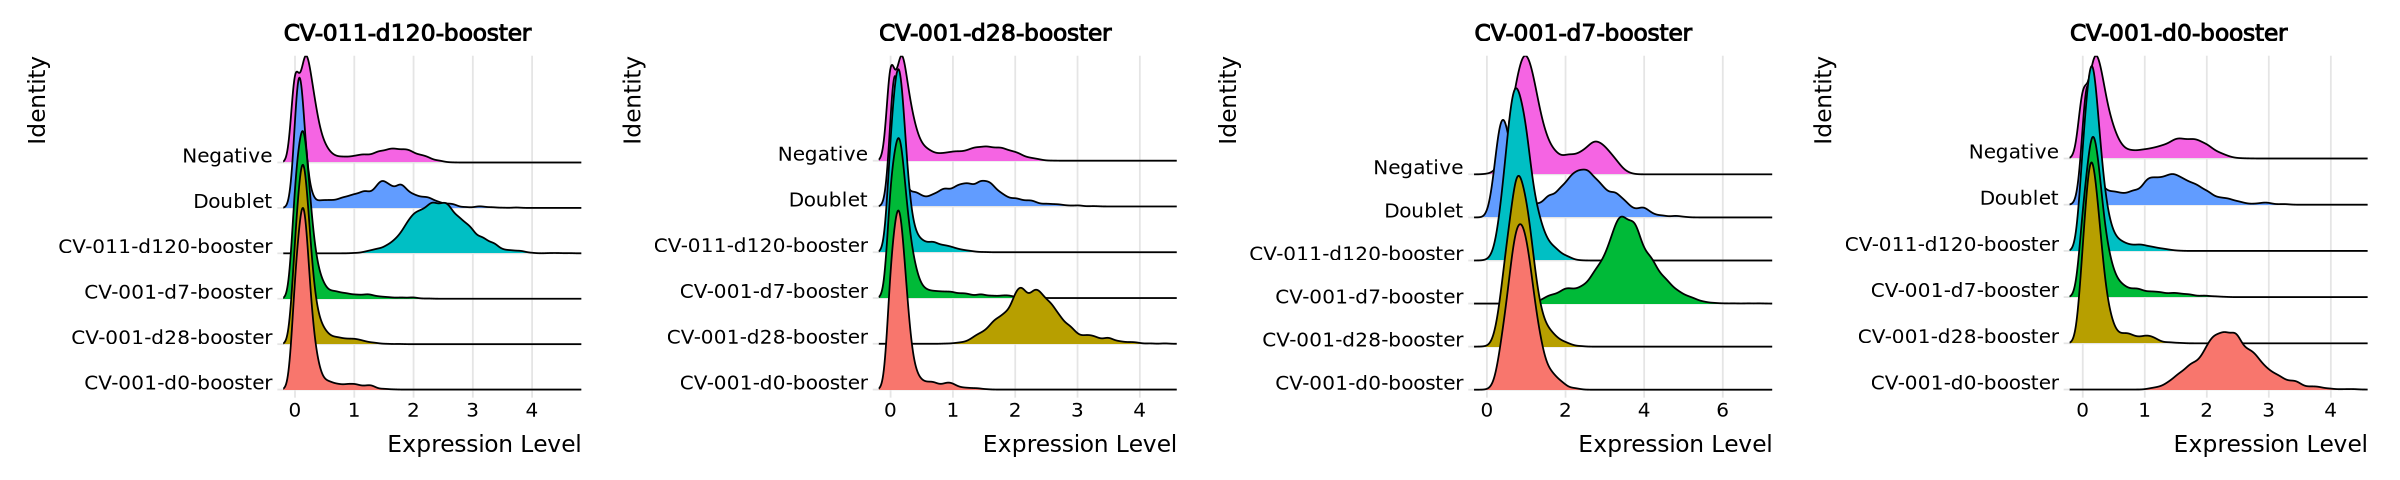

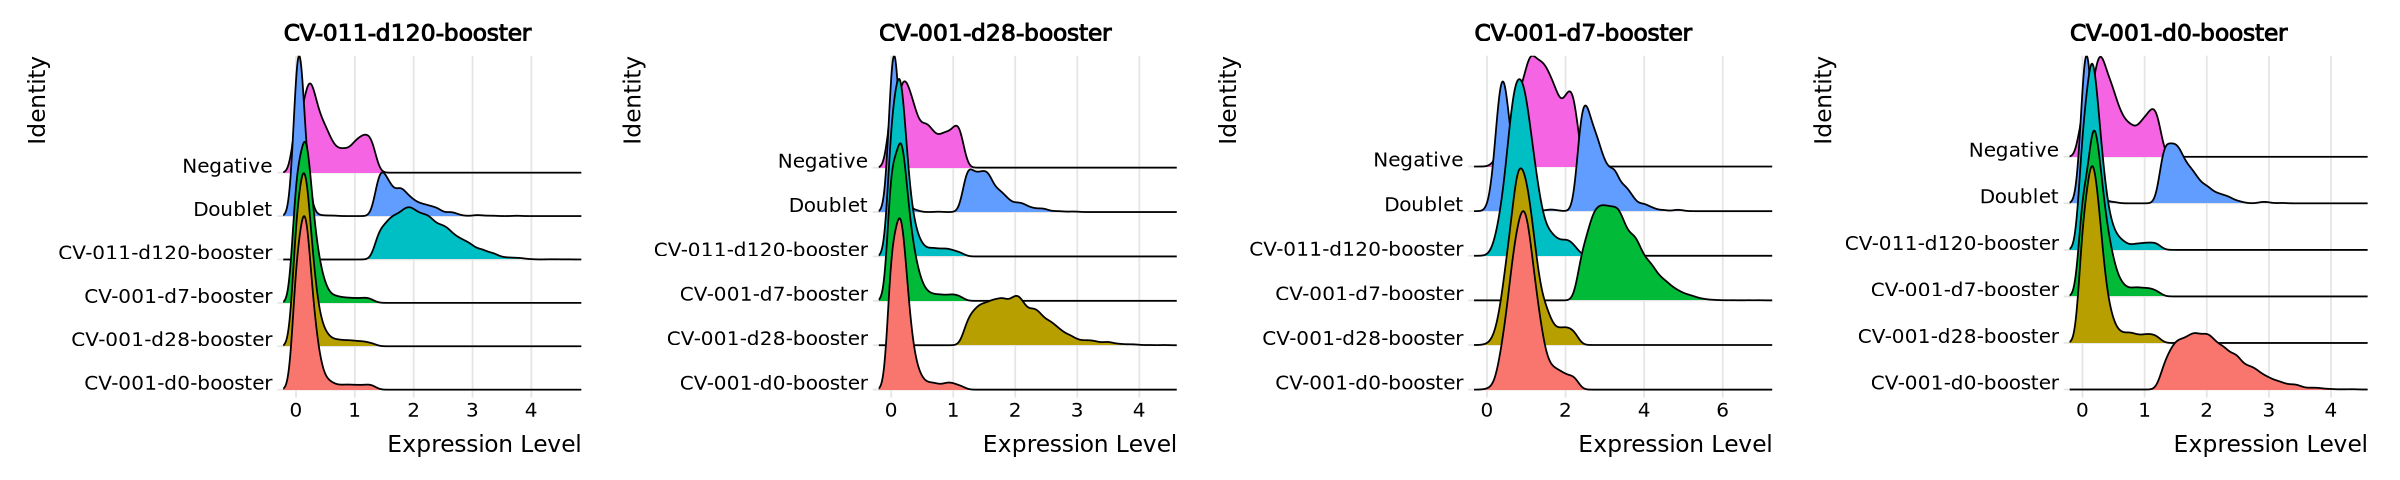

In [ ]:
# ridge plot of hashtag signals for CV10
options(repr.plot.width=20, repr.plot.height= 4)
RidgePlot(obj.list[[1]], assay = "HTO", group.by = "hash.ID", features = rownames(obj.list[[1]][["HTO"]]), ncol = 4)
RidgePlot(obj.list[[1]], assay = "HTO", group.by = "MULTI_ID", features = rownames(obj.list[[1]][["HTO"]]), ncol = 4)

Picking joint bandwidth of 0.0609

Picking joint bandwidth of 0.0685

Picking joint bandwidth of 0.0582

Picking joint bandwidth of 0.0799

Picking joint bandwidth of 0.0511

Picking joint bandwidth of 0.0622

Picking joint bandwidth of 0.044

Picking joint bandwidth of 0.0673



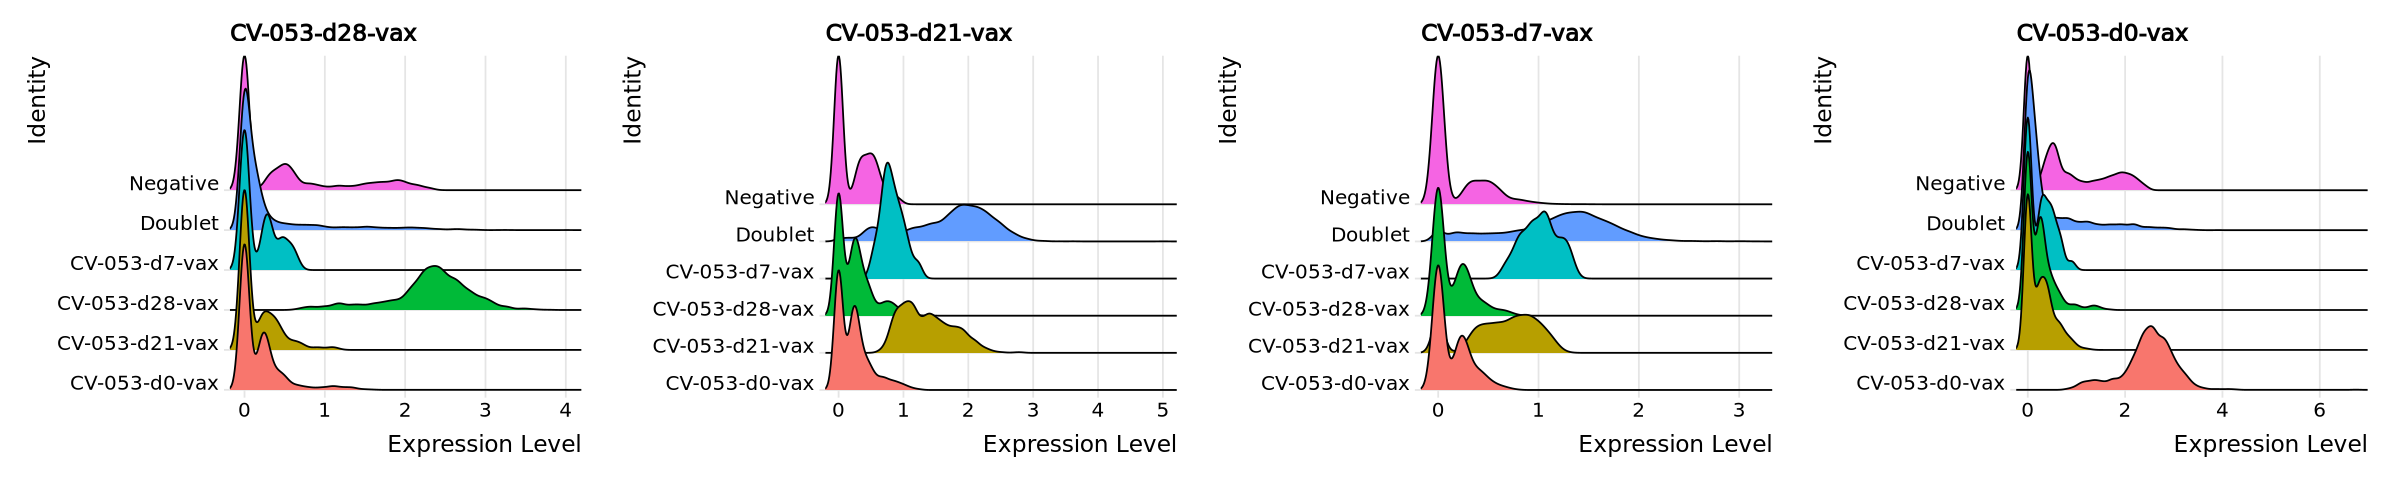

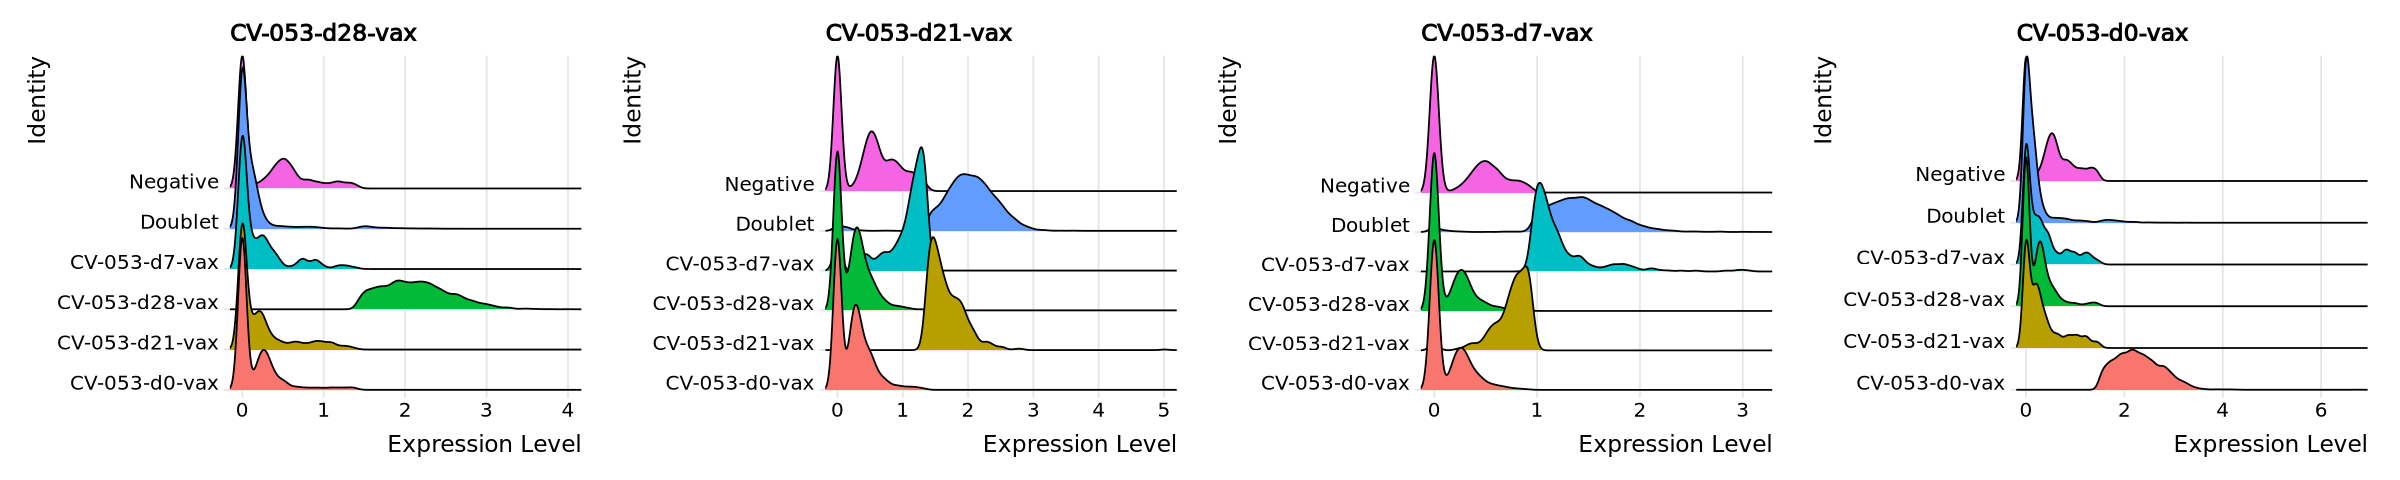

In [ ]:
# ridge plot of hashtag signals for CV12
options(repr.plot.width=20, repr.plot.height= 4)
RidgePlot(obj.list[[2]], assay = "HTO", group.by = "hash.ID", features = rownames(obj.list[[2]][["HTO"]]), ncol = 4)
RidgePlot(obj.list[[2]], assay = "HTO", group.by = "MULTI_ID", features = rownames(obj.list[[2]][["HTO"]]), ncol = 4)

## Evaluation
We will now merge the list of Seurat objects together as a single object to evaluate the demultiplexing algorithms.

> HTODemux and MULTIseqDemux algorithm outputs are mostly consistent. HTODemux called more negative cells than MULTIseqDemux.

In [4]:
# merge seurat objects and join all layers
obj <- merge(obj.list[[1]], obj.list[2:length(obj.list)])
obj <- join_layers(obj)

In [5]:
# compare outputs from HTODemux and MULTIseqDemux
table(HTODemux=obj$HTO_classification.global, MULTIseqDemux=obj$MULTI.global)

          MULTIseqDemux
HTODemux   Doublet Negative Singlet
  Doublet     4787      667    2043
  Negative     154     6089    8957
  Singlet      373      937   12843

MULTIseqDemux seem to outperform HTODemux in terms of "Singlet" assignment and comparing hashtag signals. In the following chapters, we will continue subsequent analysis using MULTIseqDemux output rather than HTODemux.

## Session Info {.unnumbered}

In [6]:
qsave(obj, "seurat/1_processing/1.3_GSE247917_demux.qs")

In [8]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scUnify_0.0.0.9000          ComplexHeatmap_2.16.0      
 [3] DoubletFinder_2.0.4         scDblFinder_1.14.0         
 [5] celda_1.16.1                Matrix_1.6-1 